In [1]:
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Polygon

##  Read data 

In [2]:
# read prior

f = open('emimtf2n_FIM_info/PR_quad_543900_scaledBar.json')

f2 = open('emimtf2n_FIM_info/PR_quad_543900_scaledBar_pressure.json')

f3 = open('emimtf2n_FIM_info/PR_quad_543900_scaledBar_under10.json')

f4 = open('emimtf2n_FIM_info/PR_quad_543900_scaledBar_under10_pressure.json')

data = json.load(f)

data_pressure = json.load(f2)

data_under10 = json.load(f3)
data_pressure_under10 = json.load(f4)

In [3]:
T_range_overall = [273, 283, 293, 303, 313, 323, 333, 343, 353, 363, 373, 383, 393, 400]
x_range_original = [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
x_range_under10 = [0.01, 0.05]

In [4]:
# read prior
def remove_fim(idx_to_remove):
    f_prior = open('emimtf2n_FIM_info/PR_quadTdep.json')

    data_prior = json.load(f_prior)

    #prior_info = data[0]['Total']
    prior_info = [[0]*6 for i in range(6)]
    
    # remove idx
    for idx in idx_to_remove:
        for a in range(6):
            for b in range(6):
                prior_info[a][b] += data_prior[0][str(idx)][a][b]

    for i in range(6):
        for j in range(6):
            prior_info[i][j] *= 10**(-10)
            
    return prior_info



In [5]:
new_prior = [2, 5, 12, 19, 23, 26]

num_to_remove = []
for i in range(27):
    if i not in new_prior:
        num_to_remove.append(i)

fim_to_be_removed = remove_fim(num_to_remove)
print(fim_to_be_removed)

[[2858.975818799478, -579.2612101929627, 5207.751301686086, -428.3489541348661, 1864.2891008357365, -283.54626365025234], [-579.2612101929627, 163.6533703488036, -1019.3277971467716, 117.80329426080242, -352.28653018832347, 75.79362291682195], [5207.751301686086, -1019.3277971467716, 9533.385527008872, -757.0268587288143, 3429.7367292757167, -503.37387249760616], [-428.3489541348661, 117.80329426080242, -757.0268587288143, 85.0357169357919, -262.8129479280551, 54.87487164384609], [1864.2891008357365, -352.28653018832347, 3429.7367292757167, -262.8129479280551, 1239.9525233939873, -175.57043835922119], [-283.54626365025234, 75.79362291682195, -503.37387249760616, 54.87487164384609, -175.57043835922119, 35.52482332193588]]


In [6]:
def read_heatmap(T_range, x_range, data_set, pressure_data_set, remove=None):
    A_heatmap = np.zeros((len(T_range), len(x_range)))
    D_heatmap = np.zeros((len(T_range), len(x_range)))
    E_heatmap = np.zeros((len(T_range), len(x_range)))
    ME_heatmap = np.zeros((len(T_range), len(x_range)))

    pressure_heatmap = np.zeros((len(T_range), len(x_range)))

    for i in range(len(T_range)):
        for j in range(len(x_range)):
            count = i*len(x_range) + j 

            #fim = np.asarray(data_set[0][str(count)])
            fim = data_set[0][str(count)]
            
            if remove:
                for a in range(6):
                    for b in range(6):
                        fim[a][b] -= remove[a][b]
                    
            fim = np.asarray(fim)

            A_heatmap[i,j] = np.trace(fim)
            D_heatmap[i,j] = np.linalg.det(fim)
            E_heatmap[i,j] = min(np.linalg.eigvals(fim))
            ME_heatmap[i,j] = np.linalg.cond(fim)

            pressure_heatmap[i,j] = pressure_data_set[0][str(count)]*0.00001
            
    return A_heatmap, D_heatmap, E_heatmap, ME_heatmap, pressure_heatmap

In [7]:
A_heatmap_ori, D_heatmap_ori, E_heatmap_ori, ME_heatmap_ori, pressure_heatmap_ori = read_heatmap(T_range_overall, x_range_original, data, data_pressure, remove=fim_to_be_removed)

A_heatmap_under10, D_heatmap_under10, E_heatmap_under10, ME_heatmap_under10, pressure_heatmap_under10 = read_heatmap(T_range_overall, x_range_under10, data_under10, data_pressure_under10, remove=fim_to_be_removed)


In [8]:

A_heatmap_overall = np.concatenate((A_heatmap_under10, A_heatmap_ori), axis=1)
D_heatmap_overall = np.concatenate((D_heatmap_under10, D_heatmap_ori), axis=1)

E_heatmap_overall = np.concatenate((E_heatmap_under10, E_heatmap_ori), axis=1)

ME_heatmap_overall = np.concatenate((ME_heatmap_under10, ME_heatmap_ori), axis=1)

pressure_heatmap_overall = np.concatenate((pressure_heatmap_under10, pressure_heatmap_ori), axis=1)


print(np.shape(A_heatmap_overall))

(14, 11)


In [9]:
#print(pressure_heatmap)

A_practical  = A_heatmap_overall.copy()
D_practical  = D_heatmap_overall.copy()
E_practical  = E_heatmap_overall.copy()
ME_practical  = ME_heatmap_overall.copy()
pressure_practical = pressure_heatmap_overall.copy()

for i in range(len(pressure_heatmap_overall)):
    for j in range(len(pressure_heatmap_overall[0])):
        if pressure_practical[i,j] > 20:
            pressure_practical[i,j] = float("NaN")
            
            A_practical[i,j] = float('NaN')
            E_practical[i,j] = float('NaN')
            D_practical[i,j] = float('NaN')
            ME_practical[i,j] = float('NaN')
print(pressure_practical)

[[ 0.0590856   8.20231711  0.60210417  1.2341964   1.9029836   2.61709913
   3.38799208  4.23039317  5.16088516  6.18748552  7.26075313]
 [ 0.07574304  0.38283534  0.77754591  1.60863724  2.50671146  3.48954593
   4.58095166  5.81138747  7.21277889  8.78595523 10.34980692]
 [ 0.09562502  0.48475871  0.98840851  2.06258909  3.24612591  4.57107057
   6.08135208  7.83451517  9.89170423 12.24717642 14.48279582]
 [ 0.11905909  0.60523182  1.23855358  2.60554072  4.1391968   5.89292597
   7.94215966 10.38982108 13.35288311 16.83449253         nan]
 [ 0.14636272  0.74596742  1.53177129  3.2469661   5.20428041  7.48805351
  10.2217326  13.58317287 17.79773593         nan         nan]
 [ 0.17783806  0.9086049   1.87171683  3.99617288  6.45987253  9.39085219
  12.9843126  17.54113453         nan         nan         nan]
 [ 0.21376681  1.09468205  2.26184706  4.86214521  7.9243366  11.63689692
  16.30063293         nan         nan         nan         nan]
 [ 0.25440529  1.30560757  2.70535827  5.

In [10]:
data_file = './emimtf2n/R32/Final_Results/MBDoE/r32_emimtf2n_subset.csv'
data_exp = pd.read_csv(data_file)
print(len(data_exp))

27


In [11]:
print(np.random.rand(6,2))

[[0.89938467 0.5863204 ]
 [0.11379716 0.75440626]
 [0.68640024 0.89739199]
 [0.66719434 0.76225181]
 [0.86145922 0.429637  ]
 [0.74831779 0.41301563]]


In [ ]:
def func(x):
    return (x - 3) * (x - 5) * (x - 7) + 85


a, b = 2, 9  # integral limits
x = np.linspace(0, 10)
y = func(x)

fig, ax = plt.subplots()
plt.plot(x, y, 'r', linewidth=2)
plt.ylim(ymin=0)

# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

#plt.text(0.5 * (a + b), 30, r"$\int_a^b f(x)\mathrm{d}x$",
#         horizontalalignment='center', fontsize=20)

plt.figtext(0.9, 0.05, '$x$')
plt.figtext(0.1, 0.9, '$y$')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.set_xticks((a, b))
ax.set_xticklabels(('$a$', '$b$'))
ax.set_yticks([])

plt.show()

In [ ]:


def func(x):
    return x*0.1

a,b=300, 400
ix = np.linspace(a, b)
iy = func(ix)

verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
#polygon1 = Polygon([[0.5,0.2], [0.4,0.3], [0.6, 0.9],], closed=True, alpha=1)

cbar.ax.add_patch(poly)

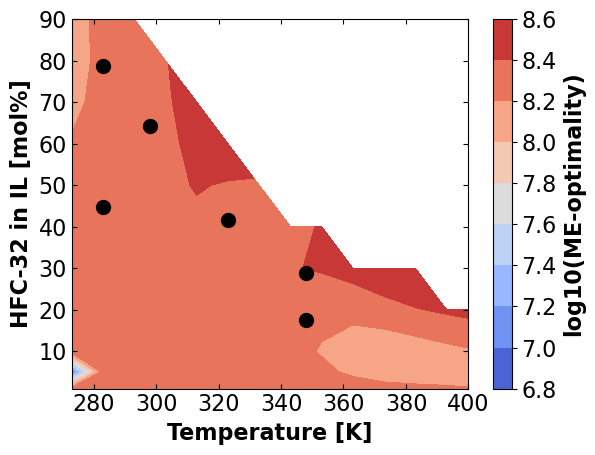

In [15]:
def contour(T_range_label, x_range_label, heatmap_data, bar_label, plot_prior=True):
    # draw figure, using (6,6) because the plot is small otherwise
    #fig, ax = plt.figure(figsize=(6,6))
    fig, ax = plt.subplots()
    
    # plot heatmap
    #   cmap defines the overall color within the heatmap 
    #   levels: determines the number and positions of the contour lines / regions.
    cs = plt.contourf(T_range_label, x_range_label, heatmap_data.T,cmap=cm.coolwarm)

    # plot color bar
    cbar = plt.colorbar(cs)

    # plot title in color bar
    cbar.ax.set_ylabel(bar_label, fontsize=16, fontweight='bold')

    # set font size in color bar
    cbar.ax.tick_params(labelsize=16)
    
    def func(x):
        return x*0.1
    
    a,b=300, 400
    ix = np.linspace(a, b)
    iy = func(ix)
    
    verts = [(a, 90)] + list(zip(ix, iy)) + [(b, 90)]
    poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
    #polygon1 = Polygon([[0.5,0.2], [0.4,0.3], [0.6, 0.9],], closed=True, alpha=1)
    
    #ax.add_patch(poly)

    # plot equipotential line
    #  [::10] means sampling 1 in every 10 samples
    #  colors define the color want to use, 'k' for black
    #  alpha is blending value, between 0 (transparent) and 1 (opaque).
    #  linestyle defines the linestyle.
    #  linewidth defines the width of line
    #cs2 = plt.contour(cs, levels=cs.levels[::10], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

    # plot the heatmap label
    #  %2.2f means keep to 2 digit
    #  fontsize defines the size of the text in figure
    #plt.clabel(cs2, fmt='%2.2f', colors='k', fontsize=16)

    # define tick size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tick_params(direction="in",top=True, right=True)

    # set squared figure
    if plot_prior:
        for i in new_prior:  
        #for i in range(len(data_exp)):
            if i==16:
                plt.scatter(data_exp.iloc[i]['temperature'], data_exp.iloc[i]['x_R32']*100, color="black",marker="*", s=150)
                
            #elif i==3:
            #    plt.scatter(data_exp.iloc[i]['temperature'], data_exp.iloc[i]['x_R32']*100, color="black",marker="^", s=125)
                
            else:
                plt.scatter(data_exp.iloc[i]['temperature'], data_exp.iloc[i]['x_R32']*100, color="black", s=100)
        
    # plot titile and x,y label
    plt.xlabel(r'Temperature [K]', fontsize=16, fontweight='bold')
    plt.ylabel(r'HFC-32 in IL [mol%]', fontsize=16, fontweight='bold')
    plt.show()

    # save figure (important for publications)
    # plt.savefig('heatmap.png',bbox_inches='tight')
    
    
T_range_lab = T_range_overall   
x_range_lab = [1, 5, 10,20,30,40,50,60,70,80,90]
#x_range_lab = [10,20,30,40,50,60]

#contour(T_range_lab, x_range_lab, np.log10(A_heatmap[:,:6]), 'log10(A-optimality)')
contour(T_range_lab, x_range_lab, np.log10(ME_practical), 'log10(ME-optimality)', plot_prior=True)

In [ ]:
contour(T_range_lab, x_range_lab, pressure_practical/10, 'Pressure [Mpa]', plot_prior=False)